## 데이터 불러오고 나누기

In [1]:
import json
import pandas as pd
from datasets import Dataset

def load_data(file_path):
    """
    JSON 데이터를 불러와 Pandas DataFrame으로 변환
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        
    data = []
    for item in json_data['data']:
        if 'annotation' in item:
            annotation = item['annotation']
            
            if 'err_sentence' in annotation and 'cor_sentence' in annotation:
                data.append({
                    'err_sentence': annotation['err_sentence'],
                    'cor_sentence': annotation['cor_sentence']
                })
                
    df = pd.DataFrame(data)
    print(df.info())
    # None 값을 빈 문자열로 대체
    df = df.fillna('')
    return df

# JSON 파일 경로
file_path_train = "/home/yjtech2/Desktop/yurim/LLM/Data/spelling/train/combined_data_train.json"
train_df = load_data(file_path_train)
train_data_dict = train_df.to_dict(orient='list')
train_dataset = Dataset.from_dict(train_data_dict)
print(len(train_dataset))


file_path_val = "/home/yjtech2/Desktop/yurim/LLM/Data/spelling/validation/combined_data_val.json"
val_df = load_data(file_path_val)
val_data_dict = val_df.to_dict(orient='list')
val_dataset = Dataset.from_dict(val_data_dict)
print(len(val_dataset))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58162 entries, 0 to 58161
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   err_sentence  58162 non-null  object
 1   cor_sentence  58162 non-null  object
dtypes: object(2)
memory usage: 908.9+ KB
None
58162
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7268 entries, 0 to 7267
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   err_sentence  7268 non-null   object
 1   cor_sentence  7268 non-null   object
dtypes: object(2)
memory usage: 113.7+ KB
None
7268


## 모델 학습

In [2]:
import os
import torch
from tqdm import tqdm
from typing import Dict
import time
from datetime import datetime
import numpy as np
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    AdamW,
    DataCollatorForSeq2Seq,
)
import matplotlib.pyplot as plt

class CustomT5Trainer:
    def __init__(self, model_name: str, **kwargs):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
        if self.device == "cuda":
            print(f"GPU Model: {torch.cuda.get_device_name(0)}")
            print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=kwargs.get("learning_rate", 2e-5))
        self.max_length = kwargs.get("max_length", 128)
        self.training_args = kwargs
        self.save_dir = kwargs.get("save_dir", "/home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi")
        
        # 저장 경로 설정
        self.best_model_path = os.path.join(self.save_dir, "pytorch_model.bin")
        self.tokenizer_path = self.save_dir
        
        # 학습 히스토리 저장을 위한 변수
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'epoch_times': [],
            'best_epoch': 0
        }

        # 디렉터리 생성
        os.makedirs(self.save_dir, exist_ok=True)

    def save_model_and_tokenizer(self, epoch=None, is_best=False):
        """최고 모델만 저장 및 이전 모델 삭제"""
        if is_best:
            # 이전 최고 모델 디렉터리 삭제
            if self.best_model_path and os.path.exists(self.best_model_path):
                print(f"Deleting previous best model at {self.best_model_path}")
                os.system(f"rm -rf {self.best_model_path}")
            
            # 새로운 최고 모델 저장
            save_path = os.path.join(self.save_dir, f"best_model_epoch_{epoch}")
            os.makedirs(save_path, exist_ok=True)
            self.model.save_pretrained(save_path)
            self.tokenizer.save_pretrained(save_path)
            torch.save(self.history, os.path.join(save_path, 'training_history.pt'))
            
            print(f"New best model saved at {save_path}")
            self.best_model_path = save_path  # 최고 모델 경로 업데이트

    def calculate_metrics(self, predictions, labels):
        """기본적인 메트릭 계산"""
        predictions = torch.argmax(predictions, dim=-1)
        correct = (predictions == labels).masked_fill(labels == -100, 0)
        accuracy = correct.sum().item() / (labels != -100).sum().item()
        return accuracy

    def train(self, train_dataset, valid_dataset=None):
        start_time = time.time()
        print(f"\nStarting training at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Model name: {self.training_args.get('model_name', 'not specified')}")
        print(f"Training parameters:")
        print(f"- Batch size: {self.training_args['batch_size']}")
        print(f"- Learning rate: {self.training_args.get('learning_rate', '2e-5')}")
        print(f"- Max length: {self.max_length}")
        print(f"- Number of epochs: {self.training_args['num_epochs']}")
        print(f"- Training samples: {len(train_dataset)}")
        if valid_dataset:
            print(f"- Validation samples: {len(valid_dataset)}")
        print("\n" + "="*50 + "\n")

        # 데이터 전처리
        print("Preprocessing training data...")
        train_dataset = train_dataset.map(
            self.preprocess_data,
            batched=True,
            remove_columns=train_dataset.column_names,
            desc="Processing training data"
        )

        if valid_dataset is not None:
            print("Preprocessing validation data...")
            valid_dataset = valid_dataset.map(
                self.preprocess_data,
                batched=True,
                remove_columns=valid_dataset.column_names,
                desc="Processing validation data"
            )

        # DataCollator 설정
        data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer,
            model=self.model,
            padding="longest",
            return_tensors="pt"
        )

        # DataLoader 준비
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.training_args["batch_size"],
            shuffle=True,
            collate_fn=data_collator
        )

        if valid_dataset is not None:
            valid_dataloader = torch.utils.data.DataLoader(
                valid_dataset,
                batch_size=self.training_args["batch_size"],
                shuffle=False,
                collate_fn=data_collator
            )

        best_val_loss = float('inf')
        early_stopping_counter = 0
        early_stopping_patience = self.training_args.get('patience', 3)

        for epoch in range(self.training_args["num_epochs"]):
            epoch_start_time = time.time()
            
            # Training
            self.model.train()
            epoch_loss = 0
            epoch_accuracy = 0
            train_steps = 0
            
            progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")
            batch_losses = []
            batch_accuracies = []
            
            for batch_idx, batch in enumerate(progress_bar):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )
                
                loss = outputs.loss
                accuracy = self.calculate_metrics(outputs.logits, labels)
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                batch_losses.append(loss.item())
                batch_accuracies.append(accuracy)
                
                # Update progress bar
                current_loss = np.mean(batch_losses[-100:])  # Moving average of last 100 batches
                current_accuracy = np.mean(batch_accuracies[-100:])
                progress_bar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'accuracy': f'{current_accuracy:.4f}',
                    'batch': f'{batch_idx + 1}/{len(train_dataloader)}'
                })

            avg_train_loss = np.mean(batch_losses)
            avg_train_accuracy = np.mean(batch_accuracies)
            
            # Validation
            if valid_dataset is not None:
                self.model.eval()
                val_losses = []
                val_accuracies = []

                print("\nRunning validation...")
                with torch.no_grad():
                    for batch in tqdm(valid_dataloader, desc="Validating"):
                        input_ids = batch["input_ids"].to(self.device)
                        attention_mask = batch["attention_mask"].to(self.device)
                        labels = batch["labels"].to(self.device)

                        outputs = self.model(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                        )
                        
                        loss = outputs.loss
                        accuracy = self.calculate_metrics(outputs.logits, labels)
                        
                        val_losses.append(loss.item())
                        val_accuracies.append(accuracy)

                avg_val_loss = np.mean(val_losses)
                avg_val_accuracy = np.mean(val_accuracies)

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    early_stopping_counter = 0
                    self.history['best_epoch'] = epoch + 1
                    print(f"\nNew best validation loss: {best_val_loss:.4f}")
                    self.save_model_and_tokenizer(epoch + 1, is_best=True)
                else:
                    early_stopping_counter += 1

            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time
            self.history['epoch_times'].append(epoch_time)

            # Save metrics
            self.history['train_loss'].append(avg_train_loss)
            if valid_dataset is not None:
                self.history['val_loss'].append(avg_val_loss)

            # Print epoch summary
            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"Time taken: {epoch_time:.2f} seconds")
            print(f"Average training loss: {avg_train_loss:.4f}")
            print(f"Training accuracy: {avg_train_accuracy:.4f}")
            if valid_dataset is not None:
                print(f"Validation loss: {avg_val_loss:.4f}")
                print(f"Validation accuracy: {avg_val_accuracy:.4f}")
                print(f"Best validation loss so far: {best_val_loss:.4f}")
                print(f"Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")

            # Save checkpoint
            if (epoch + 1) % self.training_args.get('save_every', 5) == 0:
                self.save_model_and_tokenizer(epoch + 1)

            # Early stopping
            if early_stopping_counter >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break

            print("\n" + "="*50 + "\n")
            
        print(f"Best model saved at: {self.best_model_path}")
        
        epochs = range(1, len(self.history["train_loss"]) + 1)

        # Loss 그래프
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history["train_loss"], 'r', label="Training Loss")
        if valid_dataset:
            plt.plot(epochs, self.history["val_loss"], 'b', label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()
        plt.show()

        # Accuracy 그래프 (검증 데이터가 있는 경우)
        if valid_dataset and "train_accuracy" in self.history and "val_accuracy" in self.history:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs, self.history.get("train_accuracy", []), 'r', label="Training Accuracy")
            plt.plot(epochs, self.history.get("val_accuracy", []), 'b', label="Validation Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("Training and Validation Accuracy")
            plt.legend()
            plt.grid()
            plt.show()
        
        
        # Training summary
        total_time = time.time() - start_time
        print("\nTraining Summary:")
        print(f"Total training time: {total_time:.2f} seconds")
        print(f"Best epoch: {self.history['best_epoch']}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Average epoch time: {np.mean(self.history['epoch_times']):.2f} seconds")
        
        if valid_dataset is None:
            self.save_model_and_tokenizer()
            
        

    def preprocess_data(self, examples: Dict) -> Dict:
        """데이터 전처리 함수"""
        inputs = [f"맞춤법 교정: {self._normalize_text(text)}" for text in examples["err_sentence"]]
        model_inputs = self.tokenizer(
            inputs,
            max_length=self.max_length,
            padding="longest",
            truncation=True,
            return_tensors="pt",
        ).to(self.device)

        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                examples["cor_sentence"],
                max_length=self.max_length,
                padding="longest",
                truncation=True,
                return_tensors="pt",
            ).to(self.device)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    def predict(self, text: str) -> str:
        """모델 추론 - 긴 텍스트를 청크로 나누어 처리"""
        if not isinstance(text, str):
            return ""

        try:
            # 최대 토큰 길이 설정
            max_token_length = self.max_length - 10  # 모델의 max_length에서 여유 공간 확보

            corrected_sentences = []
            
            # 청크로 나누기
            for start_idx in range(0, len(text), max_token_length):
                chunk = text[start_idx:start_idx + max_token_length]
                
                # 각 청크에 대해 맞춤법 교정
                inputs = self.tokenizer(
                    f"맞춤법 교정: {self._normalize_text(chunk)}",
                    return_tensors="pt",
                    max_length=self.max_length,
                    truncation=True,
                ).to(self.device)

                outputs = self.model.generate(
                    inputs["input_ids"], max_length=self.max_length, num_beams=5
                )
                corrected_chunk = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                corrected_sentences.append(corrected_chunk)
            
            # 모든 청크를 다시 합치기
            final_text = " ".join(corrected_sentences)
            return final_text.strip()
        
        except Exception as e:
            print(f"Error processing text: {text}")
            print(f"Error message: {str(e)}")
            return text  # 에러 발생시 원본 텍스트 반환

    def _normalize_text(self, text: str) -> str:
        return text.strip()

2024-12-05 09:44:35.751892: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 09:44:35.775839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 09:44:36.117518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
GPU Model: NVIDIA GeForce RTX 4080
Available GPU memory: 15.59 GB


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/yjtech2/Desktop/yurim/anaconda3/envs/venv-llm/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Starting training at: 2024-12-05 09:44:39
Model name: not specified
Training parameters:
- Batch size: 16
- Learning rate: 2e-05
- Max length: 512
- Number of epochs: 10
- Training samples: 58162
- Validation samples: 7268


Preprocessing training data...


Processing training data:   0%|          | 0/58162 [00:00<?, ? examples/s]

/home/yjtech2/Desktop/yurim/anaconda3/envs/venv-llm/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Preprocessing validation data...


Processing validation data:   0%|          | 0/7268 [00:00<?, ? examples/s]

Training Epoch 1: 100%|██████████| 3636/3636 [06:08<00:00,  9.86it/s, loss=0.0484, accuracy=0.9887, batch=3636/3636]



Running validation...


Validating: 100%|██████████| 455/455 [00:10<00:00, 44.93it/s]



New best validation loss: 0.0843
New best model saved at /home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_1

Epoch 1 Summary:
Time taken: 381.15 seconds
Average training loss: 0.0752
Training accuracy: 0.9840
Validation loss: 0.0843
Validation accuracy: 0.9839
Best validation loss so far: 0.0843
Early stopping counter: 0/3




Training Epoch 2: 100%|██████████| 3636/3636 [06:08<00:00,  9.85it/s, loss=0.0292, accuracy=0.9928, batch=3636/3636]



Running validation...


Validating: 100%|██████████| 455/455 [00:10<00:00, 44.99it/s]



New best validation loss: 0.0837
Deleting previous best model at /home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_1
New best model saved at /home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_2

Epoch 2 Summary:
Time taken: 381.31 seconds
Average training loss: 0.0303
Training accuracy: 0.9925
Validation loss: 0.0837
Validation accuracy: 0.9845
Best validation loss so far: 0.0837
Early stopping counter: 0/3




Training Epoch 3: 100%|██████████| 3636/3636 [06:09<00:00,  9.84it/s, loss=0.0157, accuracy=0.9961, batch=3636/3636]



Running validation...


Validating: 100%|██████████| 455/455 [00:10<00:00, 44.96it/s]



Epoch 3 Summary:
Time taken: 379.63 seconds
Average training loss: 0.0162
Training accuracy: 0.9957
Validation loss: 0.0889
Validation accuracy: 0.9846
Best validation loss so far: 0.0837
Early stopping counter: 1/3




Training Epoch 4: 100%|██████████| 3636/3636 [06:09<00:00,  9.85it/s, loss=0.0108, accuracy=0.9969, batch=3636/3636]



Running validation...


Validating: 100%|██████████| 455/455 [00:10<00:00, 44.90it/s]



Epoch 4 Summary:
Time taken: 379.26 seconds
Average training loss: 0.0097
Training accuracy: 0.9973
Validation loss: 0.0946
Validation accuracy: 0.9850
Best validation loss so far: 0.0837
Early stopping counter: 2/3




Training Epoch 5: 100%|██████████| 3636/3636 [06:09<00:00,  9.85it/s, loss=0.0062, accuracy=0.9983, batch=3636/3636]



Running validation...


Validating: 100%|██████████| 455/455 [00:10<00:00, 44.92it/s]



Epoch 5 Summary:
Time taken: 379.32 seconds
Average training loss: 0.0060
Training accuracy: 0.9984
Validation loss: 0.0990
Validation accuracy: 0.9849
Best validation loss so far: 0.0837
Early stopping counter: 3/3

Early stopping triggered after 5 epochs
Best model saved at: /home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_2


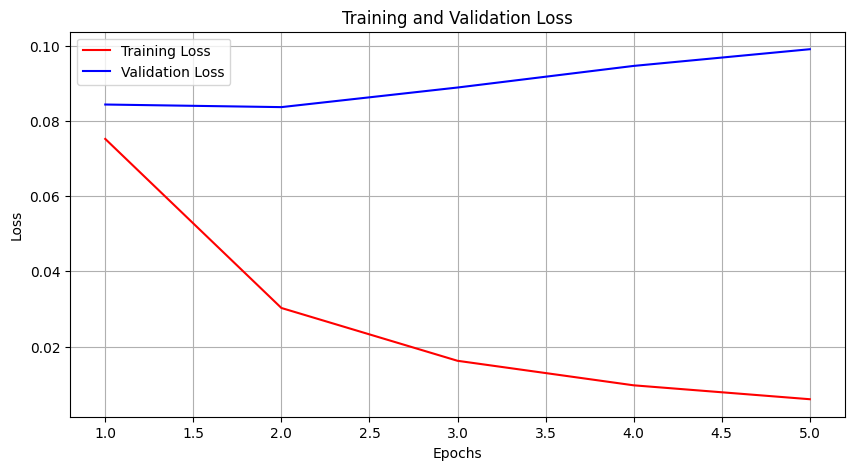


Training Summary:
Total training time: 1910.11 seconds
Best epoch: 2
Best validation loss: 0.0837
Average epoch time: 380.13 seconds


In [3]:
trainer = CustomT5Trainer(
    model_name="j5ng/et5-typos-corrector",
    max_length=512,
    learning_rate=2e-5,
    batch_size=16,
    num_epochs=10,
    gradient_accumulation_steps=4,
    patience=3  # early stopping patience
)

if __name__ == "__main__":
    torch.cuda.empty_cache()  # GPU 메모리 초기화
    trainer.train(train_dataset, val_dataset)


## 테스트

In [4]:
# from transformers import T5ForConditionalGeneration, T5Tokenizer

# model = T5ForConditionalGeneration.from_pretrained('/home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_2')
# tokenizer = T5Tokenizer.from_pretrained("/home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_2")
# print("Model and tokenizer loaded successfully.")

In [14]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# 저장된 모델 경로
saved_model_path = "/home/yjtech2/Desktop/yurim/LLM/Pre_processing/spelling/et5/best_model1_train_val2_combi/best_model_epoch_2"

# 모델과 토크나이저 불러오기
tokenizer = T5Tokenizer.from_pretrained(saved_model_path, local_files_only=True)
model = T5ForConditionalGeneration.from_pretrained(saved_model_path, local_files_only=True).to('cpu')

def apply_spelling_correction(text):
    """문장 끝 점을 기준으로 텍스트를 나누어 각 문장을 교정한 후 다시 합치기"""
    if not isinstance(text, str):
        return ""

    try:
        # 문장 단위로 분리 (여기서 문장 끝 점(`.`)을 기준으로 나눕니다)
        sentences = text.split('.') 

        corrected_sentences = []
        
        for sentence in sentences:
            sentence = sentence.strip()  # 불필요한 공백 제거
            
            # 각 문장에 대해 맞춤법 교정
            if len(sentence) == 0:
                continue
            
            inputs = tokenizer(
                f"맞춤법 교정: {sentence}",
                return_tensors="pt",
                max_length=512,
                truncation=True,
            ).to("cpu")

            outputs = model.generate(
                inputs["input_ids"], 
                max_length=512, 
                num_beams=5,
                length_penalty=0.6,
                early_stopping=True
            )

            corrected_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
            corrected_sentences.append(corrected_sentence)

        # 교정된 문장들을 다시 합침
        final_text = " ".join(corrected_sentences)  # 다시 문장 끝에 '。'을 추가
        return final_text.strip()

    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error message: {str(e)}")
        return text  # 에러 발생시 원본 텍스트 반환

# 예측 테스트
text = "안녕하세요. 포항시 오천읍에 거주하는 이강일입니다. 저는 지난 11월 13일 이후로 집에서 나오는 수돗물에서 고약한 냄새가 나기 시작했습니다. 처음에는 아파트 물탱크의 문제가 있는 줄 알고 대수롭지 않게 여겼는데 냄새가 계속 나서 걱정이 돼서 신고합니다. 현재 수돗물에서 흙냄새와 곰팡이 냄새가 나고 그래서 설거지나 세수는 물론 물을 마실 수가 없습니다. 생수로 대체해서 사용하고 있는데 이 문제로 매우 불편을 겪고 있습니다. 포항시 수돗물 원수의 40%를 공급하는 경주 안개 때문에 녹조 현상이 발생했다고 들었고 남조류에서 발생한 지오스민이 냄새를 유발한다고 합니다. 이 문제에 대한 빠른 대응을 부탁드립니다. 감사합니다."

# 문장 끝 기준으로 처리
result = apply_spelling_correction(text)
print("원래 문장: ", text)
print("교정 후 문장: ", result)


원래 문장:  안녕하세요. 포항시 오천읍에 거주하는 이강일입니다. 저는 지난 11월 13일 이후로 집에서 나오는 수돗물에서 고약한 냄새가 나기 시작했습니다. 처음에는 아파트 물탱크의 문제가 있는 줄 알고 대수롭지 않게 여겼는데 냄새가 계속 나서 걱정이 돼서 신고합니다. 현재 수돗물에서 흙냄새와 곰팡이 냄새가 나고 그래서 설거지나 세수는 물론 물을 마실 수가 없습니다. 생수로 대체해서 사용하고 있는데 이 문제로 매우 불편을 겪고 있습니다. 포항시 수돗물 원수의 40%를 공급하는 경주 안개 때문에 녹조 현상이 발생했다고 들었고 남조류에서 발생한 지오스민이 냄새를 유발한다고 합니다. 이 문제에 대한 빠른 대응을 부탁드립니다. 감사합니다.
교정 후 문장:  안녕하세요? 포항 시에 거주하는 이강일입니다. 저는 지난 11월 13일 이후로 집에서 나오는 수돗물에서 고약한 냄새가 나기 시작했습니다. 처음에는 아파트 물탱크의 문제가 있는 줄 알고 대수롭지 않게 여겼는데 냄새가 계속 나서 걱정이 돼서 신고합니다. 현재 수돗물에서 흙 냄새와 곰팡이 냄새가 나고 그래서 설거지나 세수는 물론 물을 마실 수가 없습니다. 생수로 대체해서 사용하고 있는데 이 문제로 매우 불편을 겪고 있습니다. 포항 시 수돗물 원수의 40%를 공급하는 경주 안개 때문에 녹조 현상이 발생했다고 들었고 남조류에서 발생한 지오스민이 냄새를 유발한다고 합니다. 이 문제에 대한 빠른 대응을 부탁드립니다. 감사합니다.


In [8]:
print(len(result))
print(len(text))

240
364
